In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:100% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:22pt;}
div.text_cell_render.rendered_html{font-size:18pt;}
div.text_cell_render.rendered_html{font-size:15pt;}
div.output {font-size:18pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:18pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:18pt;padding:5px;}
table.dataframe{font-size:18px;}
</style>
"""))

<b><font size="5" color="red">ch10_iris(다중분류)</font></b>

In [3]:
# import
import numpy as np
import seaborn as sns # iris데이터
import pandas as pd   # 원핫인코딩
from sklearn.preprocessing import LabelEncoder # 라벨인코딩(문자->숫자)
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from sklearn.model_selection import train_test_split # 데이터 분할(층화추출로)
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt # 학습과정 시각화

- iris데이터
1. sepal_length : 꽃받침길이
2. sepal_width : 꽃받침넓이
3. petal_length : 꽃잎길이
4. petal_width : 꽃잎침넓이
5. species : 종(setosa, versicolor, virginica)

In [4]:
# 문자변수의 원핫인코딩 방법1
iris = sns.load_dataset('iris')
# to_categorical(iris['species'])
labelEncoder = LabelEncoder()
# labelEncoder.fit(iris['species'])
# iris['y'] = labelEncoder.transform(iris['species'])
iris['y'] = labelEncoder.fit_transform(iris.species)
# iris.iloc[::25]
to_categorical(iris['y'])[::25] # to_categorical의 결과는 numpy배열

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [5]:
# 문자변수 원핫인코딩 방법2
iris = sns.load_dataset('iris')
pd.get_dummies(iris.species).values # pd.get_dummies결과는 데이터프레임
pd.get_dummies(iris.species).to_numpy()[::25]

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [6]:
# 1. 데이터 생성 및 전처리
iris = sns.load_dataset('iris')
# iris.info() 결측치있으면 결측치 처리
# iris['species'].value_counts() 타겟변수의 분포
# 독립변수와 타겟변수 분리
iris_X = iris.iloc[:, :-1].to_numpy()
# iris_X[:2]
iris_y = iris.iloc[:, -1]
iris_Y = pd.get_dummies(iris_y).values
# iris_Y[::50]
# 훈련셋 : 테스트셋 = 8 : 2
X_train, X_test, Y_train, Y_test = train_test_split(iris_X, iris_Y,
                                                    train_size=0.8, # 훈련셋비율
                                                   #test_size=0.2,  #테스트 비율
                                                   stratify=iris_Y,#층화추출
                                                   random_state=7 # 랜덤시드값
                                                   )
print(iris_X.shape, iris_Y.shape)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(150, 4) (150, 3)
(120, 4) (30, 4) (120, 3) (30, 3)


In [7]:
# 층화추출이 되었는지 확인
# iris_Y.argmax(axis=1)
print( pd.Series(np.argmax(iris_Y, axis=1)).value_counts() )
print( pd.Series(np.argmax(Y_train, axis=1)).value_counts() )
print( pd.Series(np.argmax(Y_test, axis=1)).value_counts() )

0    50
1    50
2    50
dtype: int64
0    40
2    40
1    40
dtype: int64
0    10
2    10
1    10
dtype: int64


In [8]:

# 2. 모델구성(입력4, 출력3)
model = Sequential()
model.add(Dense(units=64, input_dim=4, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=50,  activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=30,  activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=3,  activation='softmax')) # 출력층
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                6450      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 30)                1530      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0

In [9]:
# 3. 학습과정 설정
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
# 4. 학습 : epoch마다 val_accuracy값이 좋아지고 있으면 model 자동 저장(콜백추가)
    # 모델 자동 저장될 경로 : ./model/iris-002-val0.8745.h5
import os
model_save_folder = './model_iris/'
if not os.path.exists(model_save_folder): # 폴더가 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'iris-{epoch:03d}-val{val_accuracy:.4f}.h5'
# 모델 자동 저장할 콜백 객체
checkpoint = ModelCheckpoint(filepath=file,
                            monitor='val_accuracy', # 모니터링 지표 (기본값:val_loss)
                            mode='max',
                            save_best_only=True, # False : 매번 저장
                            verbose=1) # 모델 저장시 로그 출력 (0:로그출력안함)
# 조기 종료 콜백 객체
earlyStopping = EarlyStopping(patience=40) # monitor기본값은 val_loss
hist = model.fit(X_train, Y_train,
                #batch_size=40,
                epochs=500,
                validation_split=0.2, # 훈련셋의 20%를 검증셋
                callbacks=[earlyStopping, checkpoint])

Epoch 1/500
1/3 [=========>....................] - ETA: 1s - loss: 1.2059 - accuracy: 0.3438
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to ./model_iris\iris-001-val0.7500.h5
3/3 [==============================] - 1s 152ms/step - loss: 1.1457 - accuracy: 0.3854 - val_loss: 1.0296 - val_accuracy: 0.7500
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 1.0079 - accuracy: 0.6250
Epoch 2: val_accuracy did not improve from 0.75000
3/3 [==============================] - 0s 17ms/step - loss: 1.0225 - accuracy: 0.5000 - val_loss: 0.9487 - val_accuracy: 0.5833
Epoch 3/500
1/3 [=========>....................] - ETA: 0s - loss: 1.0281 - accuracy: 0.4062
Epoch 3: val_accuracy did not improve from 0.75000
3/3 [==============================] - 0s 21ms/step - loss: 0.9688 - accuracy: 0.4583 - val_loss: 0.8490 - val_accuracy: 0.6667
Epoch 4/500
1/3 [=========>....................] - ETA: 0s - loss: 0.8744 - accuracy: 0.5625
Epoch 4: val_accuracy did not improve

1/3 [=========>....................] - ETA: 0s - loss: 0.2529 - accuracy: 0.8750
Epoch 30: val_accuracy did not improve from 0.91667
3/3 [==============================] - 0s 17ms/step - loss: 0.2370 - accuracy: 0.9062 - val_loss: 0.1946 - val_accuracy: 0.9167
Epoch 31/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2415 - accuracy: 0.9375
Epoch 31: val_accuracy did not improve from 0.91667
3/3 [==============================] - 0s 17ms/step - loss: 0.2101 - accuracy: 0.9271 - val_loss: 0.2215 - val_accuracy: 0.9167
Epoch 32/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2297 - accuracy: 0.9062
Epoch 32: val_accuracy did not improve from 0.91667
3/3 [==============================] - 0s 16ms/step - loss: 0.1992 - accuracy: 0.9167 - val_loss: 0.2027 - val_accuracy: 0.9167
Epoch 33/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1557 - accuracy: 0.9375
Epoch 33: val_accuracy did not improve from 0.91667
3/3 [==============================] - 0s 16m

Epoch 60/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0291 - accuracy: 1.0000
Epoch 60: val_accuracy did not improve from 0.91667
3/3 [==============================] - 0s 19ms/step - loss: 0.0916 - accuracy: 0.9792 - val_loss: 0.2088 - val_accuracy: 0.9167
Epoch 61/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0898 - accuracy: 0.9688
Epoch 61: val_accuracy did not improve from 0.91667
3/3 [==============================] - 0s 18ms/step - loss: 0.0997 - accuracy: 0.9583 - val_loss: 0.2119 - val_accuracy: 0.9167
Epoch 62/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0556 - accuracy: 0.9688
Epoch 62: val_accuracy did not improve from 0.91667
3/3 [==============================] - 0s 16ms/step - loss: 0.0869 - accuracy: 0.9583 - val_loss: 0.2140 - val_accuracy: 0.9167
Epoch 63/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0607 - accuracy: 0.9688
Epoch 63: val_accuracy did not improve from 0.91667
3/3 [===========================

Epoch 90/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0349 - accuracy: 1.0000
Epoch 90: val_accuracy did not improve from 0.95833
3/3 [==============================] - 0s 17ms/step - loss: 0.0932 - accuracy: 0.9792 - val_loss: 0.3099 - val_accuracy: 0.9167
Epoch 91/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1576 - accuracy: 0.9375
Epoch 91: val_accuracy did not improve from 0.95833
3/3 [==============================] - 0s 16ms/step - loss: 0.0690 - accuracy: 0.9792 - val_loss: 0.2567 - val_accuracy: 0.9167


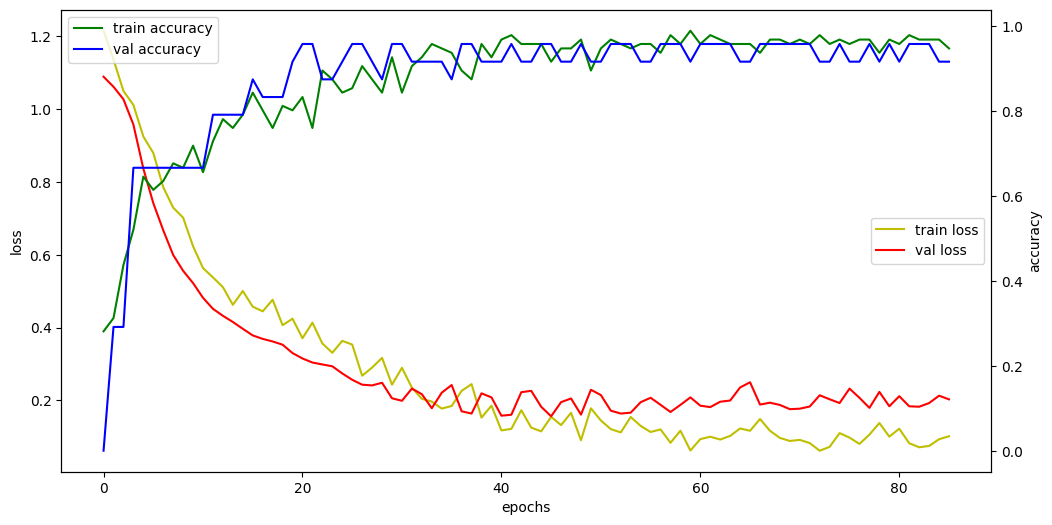

In [16]:
# 5. 모델 학습과정 시각화
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(loc='upper left')
plt.show()

In [10]:
# 6. 모델 평가(evaluate:테스트셋, 교차표,recall,precision:y실제값,y예측값)
# iris-017-val0.9583.h5 모델도 같이 평가
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score
# 학습된 모델
loss, acc = model.evaluate(X_test, Y_test, verbose=0)
loss, acc 
# 학습완료된 모델의 recall과 precision을 위해서 실제값과 예측값
real = np.argmax(Y_test, axis=1)
pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
recall = recall_score(real, pred, average='weighted') # average='weighted':다중분류
precision = precision_score(real, pred, average='weighted')
f1     = f1_score(real, pred, average='weighted')
print('model loss :', loss)
print('model accuracy :', acc)
print('model recall :', recall)
print('model precision :', precision)
print('model f1 score :', f1)
# 저장된 모델의 평가
model2 = load_model('model_iris/iris-017-val0.9583.h5')
loss, acc = model2.evaluate(X_test, Y_test, verbose=0)
pred = model2.predict(X_test, verbose=0).argmax(axis=1)
recall = recall_score(real, pred, average='weighted')
precision = precision_score(real, pred, average='weighted')
f1 = f1_score(real, pred, average='weighted')
print('model2 loss :', loss)
print('model2 acc :', acc)
print('model2 recall :', recall)
print('model2 precision :', precision)
print('model2 f1 :', f1)

model loss : 0.00910976529121399
model accuracy : 1.0
model recall : 1.0
model precision : 1.0
model f1 score : 1.0


OSError: No file or directory found at model_iris/iris-017-val0.9583.h5

In [11]:
# 교차표
pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
pd.crosstab(real, pred,
         rownames=['real'], colnames=['pred'])

pred,0,1,2
real,,,
0,10,0,0
1,0,10,0
2,0,0,10


In [12]:

confusion_matrix(real, pred)

array([[10,  0,  0],
       [ 0, 10,  0],
       [ 0,  0, 10]], dtype=int64)

In [13]:

# 모델 저장 및 사용
save_model(model, 'model/iris.h5')
model.save('model/iris.h5') # tensorflow2.18이상일 경우 확장자를 .keras로도 사용할 수 있음

In [14]:

# 모델 예측하기
# iris.loc[100] (6.3, 3.3, 6.0, 2.5) 예측하기
result = model.predict([[6.3, 3.3, 6.1, 2.5]])
np.argmax(result) # virginica로 예측

1/1 [==============================] - 0s 37ms/step


2